# Load Data

Here we load the county shapefile, and the elevation raster

Some references:

- The dataset that we are using can be found [here](https://lpdaac.usgs.gov/dataset_discovery/measures/measures_products_table/srtmgl30_v021).
- We are using the excellent [rasterio library](https://github.com/mapbox/rasterio/) to perform a raster by vector mask of the digital elevation model. 

In [27]:
%matplotlib inline

import fiona
import rasterio
from rasterio.tools.mask import mask
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Load List of Counties from Shapefile

Each item in `counties` has the following keys: 'geometry', 'type', 'properties', and 'id'. The 'geometry' value describes the county boundary and is used by rasterio to clip the Digital Elevation Model (DEM) raster. The 'properties' raster has information about the county such as: name, geoid, etc.

In [39]:
shapefile = fiona.open("data/countyBoundaries/countyBoundaries2.shp", "r")
counties = list(shapefile)
shapefile.close()

## Load the Digital Elevation Model (DEM) Raster

`usRaster.tif` is a clipped version of the concatenated DEM files from our dataset.

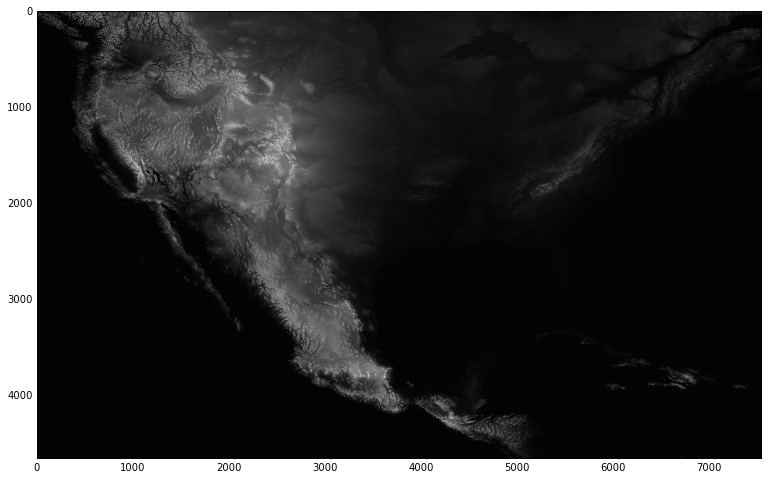

In [44]:
src = rasterio.open("usRaster.tif")
data = src.read()
src.close()

# rasterio returns a 3-dimensional array of shape (1,width,height), we need to remove the first axis to visualize
data = data.squeeze()


plt.figure(figsize=(16, 8))
plt.imshow(data, interpolation='bilinear', cmap=cm.gray, alpha=1.0)
plt.grid(False)
plt.show()

## Write Masked Counties to TIFFS

Here we individually mask all the counties from the county shapefile.

In [46]:
WRITE_ALL_TIFFS = False

if WRITE_ALL_TIFFS:
    for county in counties:
        try:
            geoms = [county["geometry"]] #the county polygon that we are masking by
            outFn = county["properties"]['GEOID']+"_"+county["properties"]['NAME'] #filename

            
            src = rasterio.open("usRaster.tif")
            out_image, out_transform = mask(src, geoms, crop=True)
            out_meta = src.meta.copy()
            src.close()

            out_meta.update(
                {
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                }
            )

            dest = rasterio.open("tmp/%s.tif" % (outFn), "w", **out_meta)
            dest.write(out_image)
            dest.close()
        except ValueError as e:
            #mask() will throw an exception when the input geometry doesn't overlap the raster
            pass

# Calculate Per County Water Coverages

       meters_0
count        67
mean          0
std           0
min           0
25%           0
50%           0
75%           0
max           0


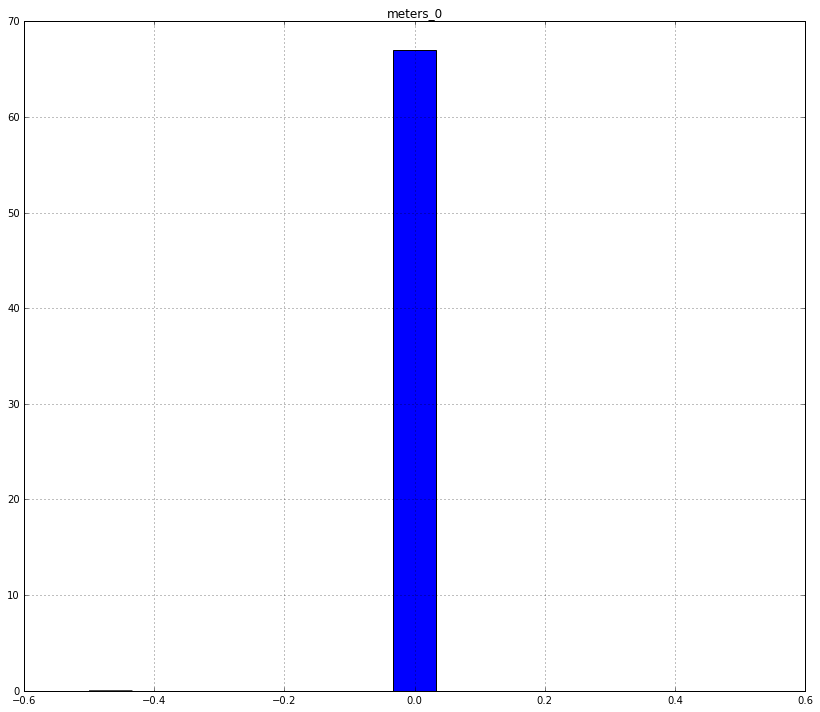

In [53]:
stateFp = "12"


countyIds = [county["properties"]['GEOID'] for county in counties if county["properties"]['STATEFP']==stateFp]

dfColumns = dict()

for seaLevelRiseAmount in range(1):
    
    tempData = []
    
    for county in counties:
        if county["properties"]["STATEFP"] == stateFp:

            countyId = county["properties"]['GEOID']
            countyName = county["properties"]['NAME']
            geoms = [county["geometry"]]

            src = rasterio.open("usRaster.tif")
            out_image, out_transform = mask(src, geoms, crop=True, nodata=0)
            src.close()

            totalNum = out_image.count()
            numAffected = np.sum((out_image <= seaLevelRiseAmount) & (out_image > 0))

            percentAffected = numAffected / float(totalNum)
            tempData.append(percentAffected)
            
    
    dfColumns["meters_%d"%seaLevelRiseAmount] = tempData
            
df = pd.DataFrame(dfColumns, index=countyIds)
print df.describe()

plt.figure()
#column=["meters_0", "meters_1", "meters_2"], 
df.hist(figsize=(14,12), sharey=True, sharex=True, bins=15)
plt.show()
